In [1]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv

--2021-03-23 14:18:01--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: 'house_prices_train.csv.1'

house_prices_train. 100%[===================>] 449.88K  1.52MB/s    in 0.3s    

2021-03-23 14:18:02 (1.52 MB/s) - 'house_prices_train.csv.1' saved [460676/460676]

--2021-03-23 14:18:02--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib. pyplot as plt
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(style='whitegrid', context='notebook')

In [2]:
data = pd.read_csv('house_prices_train.csv')
test = pd.read_csv('house_prices_test.csv')

In [3]:
data.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

In [5]:
y =np.log10(data.SalePrice)
# data.drop('SalePrice', axis=1, inplace=True)

In [6]:
[print(f"{str(td).split()[1]} => {data.select_dtypes(td).shape[1]}") for td in (object, int, float)];

'object'> => 43
'int'> => 35
'float'> => 3


In [7]:
drop_categorical_column = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [8]:
data.drop(drop_categorical_column, axis=1, inplace=True)
test.drop(drop_categorical_column, axis=1, inplace=True)

In [9]:
data.select_dtypes(exclude=["number","bool_",]).isna().sum()

MSZoning           0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
KitchenQual        0
Functional         0
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PavedDrive         0
SaleType           0
SaleCondition      0
dtype: int64

In [10]:
categorical_train = pd.get_dummies(data.select_dtypes(exclude=["number","bool_",]))
categorical_test = pd.get_dummies(test.select_dtypes(exclude=["number","bool_",]))

numerical_train = pd.get_dummies(data.select_dtypes(exclude=["object_"]))
numerical_test = pd.get_dummies(test.select_dtypes(exclude=["object_"]))

training_set = pd.concat([categorical_train, numerical_train], axis=1)
test_set = pd.concat([categorical_test, numerical_test], axis=1)

In [11]:
isna = pd.DataFrame(training_set.isnull().sum())
isna = isna.reset_index()
isna.rename(columns={'index' : 'features',
             0 : 'na'}, inplace=True)
for ft in list(isna.query("na > 0").features):
    training_set[ft].fillna(training_set[ft].median(), inplace=True)

In [12]:
isna = pd.DataFrame(training_set.isnull().sum())
isna = isna.reset_index()
isna.rename(columns={'index' : 'features',
             0 : 'na'}, inplace=True)

In [13]:
isna.query("na > 0")

,features,na


In [14]:
features = training_set.corr()[['SalePrice']].query("SalePrice > 0.5 or SalePrice <-0.5")[:-1]
features = features.reset_index()
features.rename(columns={'index': 'features',
                         'SalePrice' : 'Corr'}, inplace = True)

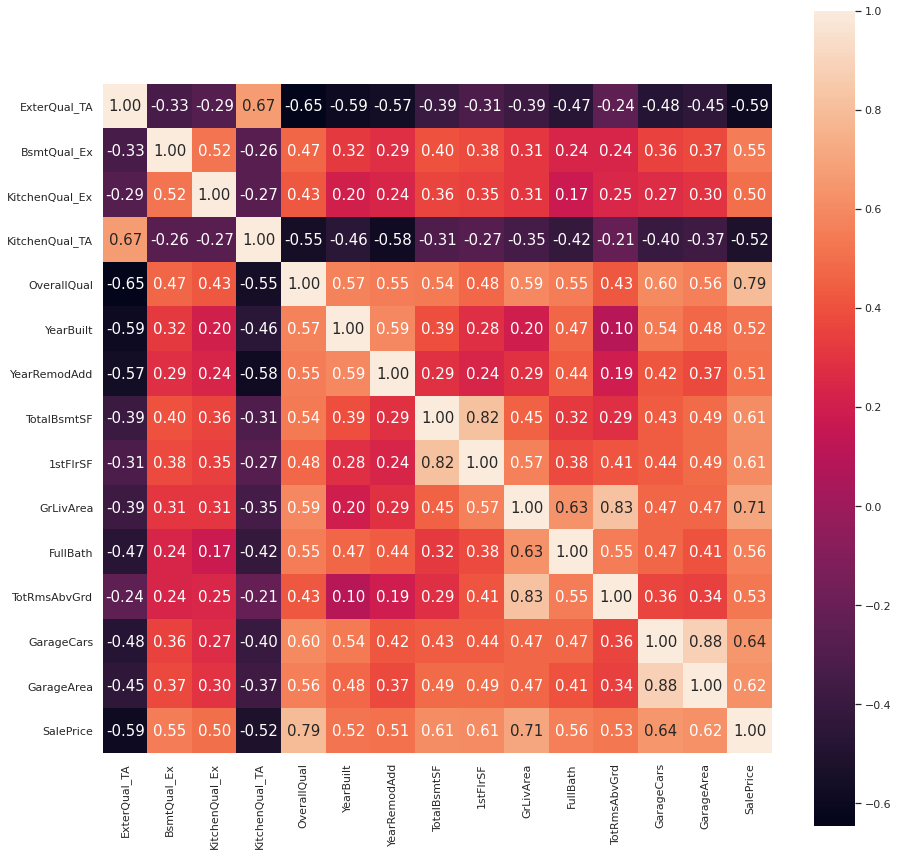

In [15]:
cm = np.corrcoef(training_set[[*features.features, 'SalePrice']].values.T)
sns.set(font_scale=1.5)
sns.set(rc={'figure.figsize' : (15, 15)})
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.02f', annot_kws={'size':15}, yticklabels=[*features.features, 'SalePrice'],
                 xticklabels=[*features.features, 'SalePrice'])
plt.show()

In [16]:
isna = pd.DataFrame(test_set.isnull().sum())
isna = isna.reset_index()
isna.rename(columns={'index' : 'features',
             0 : 'na'}, inplace=True)
for ft in list(isna.query("na > 0").features):
    test_set[ft].fillna(test_set[ft].median(), inplace=True)

In [17]:
X_train = training_set[features.features]
X_test = test_set[features.features]

In [18]:
quad = PolynomialFeatures(degree=2)
X_q_train = quad.fit_transform(X_train)
X_q_test = quad.fit_transform(X_test)

In [19]:
lr = LinearRegression()
lr.fit(X_q_train, y)

LinearRegression()

In [20]:
np.sqrt(mean_squared_error(y, lr.predict(X_q_train)))

0.06071032495313871

In [21]:
pd.DataFrame({'Id': test.Id,
              'SalePrice' : 10 ** lr.predict(X_q_test)}).to_csv('Save.csv', index=False)

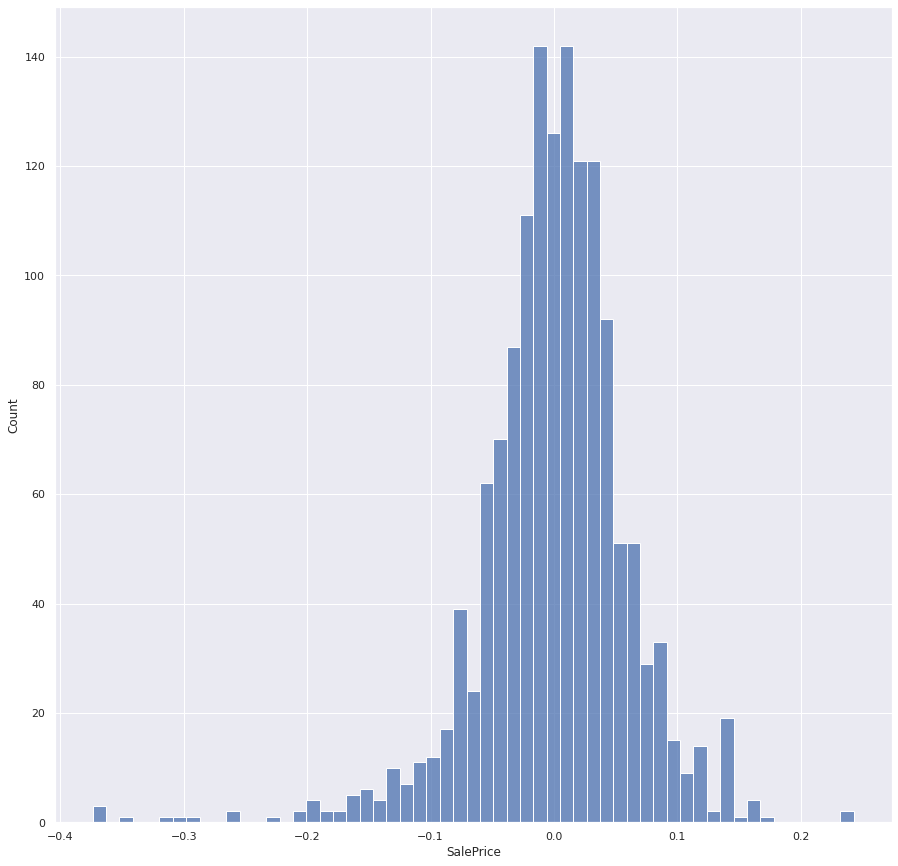

In [22]:
sns.histplot(y - lr.predict(X_q_train));